In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2

import sys
sys.path.append('../')
from Utils import utils_nn as utlnn

In [ ]:
x_test = pd.read_excel("../Train_Test/Dataset_Separado/x_test_new.xlsx")
x_train = pd.read_excel("../Train_Test/Dataset_Separado/x_train_new.xlsx")
y_test = pd.read_excel("../Train_Test/Dataset_Separado/y_test_new.xlsx")
y_train = pd.read_excel("../Train_Test/Dataset_Separado/y_train_new.xlsx")
# Se Verificó que las alturas comienzan desde R0 si el valor inicial es 6.371E6 estamos con R0 incluido.
# Tenemos que quitar ese R0 inicial de las alturas para el entrenamiento y para evitar alturas negativas aplicamos modulo.

In [ ]:
# De mi y_train y y_test solo quiero las coordenadas Z
R0 = 6.371E6
out_z_coord = [f'alt_{i}' for i in range(1,201)]
y_train_z = y_train[out_z_coord] - R0
y_test_z = y_test[out_z_coord] - R0 
# 'y_test_z son las columnas filtradas de las 3 coordenadas'
y_train_z = y_train_z.abs()
y_test_z = y_test_z.abs()

In [ ]:
from pandas.api.types import is_numeric_dtype

def info_dataset(df, name):
	print(f"Información Min-Max del dataframe: {name}:{df.shape}")	
	for i, col_name in enumerate(df.columns):
		col = df[col_name]
		# si no es numerica la ignoro, como lo hace ella conmigo.
		if not is_numeric_dtype(col):
			print(f"Columna {i} ({col_name}) no es numerica, se ignora.")
			continue
		print(f"Columna {i} ({col_name}): min={col.min():.4f}, max={col.max():.4f}, mean={col.mean():.4f}, std={col.std():.4f}")

# Gracias a la función pude observar una anomalía en los datos de y_train_z, que puede ser resuelta con un simple preprocesamiento.
# Alturas negativas no tienen sentido en este contexto.
# info_dataset(y_train_z, "y_train_z")
# Quitamos del train test xq year no varia, mmdd pasa en forma de sen y cos, hour igualmente
def drop_unnecessary_columns(x_train, x_test):
	x_train = x_train.drop(columns = ['year', 'mmdd_modified', 'mmdd','day_of_year', 'hour'])
	x_test = x_test.drop(columns =['year', 'mmdd_modified', 'mmdd','day_of_year', 'hour'])
	return x_train, x_test
x_train, x_test = drop_unnecessary_columns(x_train, x_test)


Información Min-Max del dataframe: y_train_z:(29977, 200)
Columna 0 (alt_1): min=0.0000, max=967.7734, mean=34.5070, std=150.4915
Columna 1 (alt_2): min=0.0000, max=4830.6334, mean=1227.7708, std=665.8072
Columna 2 (alt_3): min=0.0009, max=9675.9811, mean=2507.8030, std=1332.7501
Columna 3 (alt_4): min=1.5971, max=14536.1726, mean=3878.7076, std=1969.4474
Columna 4 (alt_5): min=0.7039, max=19410.9981, mean=5273.4198, std=2564.9557
Columna 5 (alt_6): min=4.4097, max=24300.2182, mean=6662.1439, std=3176.4037
Columna 6 (alt_7): min=9.9492, max=29204.2055, mean=8053.6555, std=3779.8459
Columna 7 (alt_8): min=0.5763, max=34123.0016, mean=9438.1208, std=4395.1892
Columna 8 (alt_9): min=25.6304, max=39056.2009, mean=10826.6331, std=5010.7811
Columna 9 (alt_10): min=24.3595, max=44004.0823, mean=12223.9242, std=5620.9888
Columna 10 (alt_11): min=38.0584, max=48966.7294, mean=13629.0301, std=6229.2046
Columna 11 (alt_12): min=27.7157, max=53943.7318, mean=15040.1009, std=6839.9561
Columna 12 (a

De toda la Información anterior observo que las columnas como.
latitude_pos_tx: -42.28 (valor único y constante)
longitude_pos_tx: -63.40 (valor único y constante)
elevation_pos_tx: 0.0 (valor único y constante)
year: 2010 (valor único y constante)

Estas 4 columnas tienen desviacion estándar 0, es decir, no aportan nada al aprendizaje del modelo.\
**Nota**: Los modelos de ML aprenden de las variaciones, y esas columnas no tienen ninguna.\
Procedemos a quitarlos del x_train/test

Información Min-Max del dataframe: y_train_z:(29977, 200)
Columna 0 (alt_1): min=-0.0000, max=967.7734, mean=34.5070, std=150.4915
Columna 1 (alt_2): min=-214.3333, max=4830.6334, mean=1225.7706, std=669.4825
Columna 2 (alt_3): min=-304.1357, max=9675.9811, mean=2502.7084, std=1342.2928
Columna 3 (alt_4): min=-303.8887, max=14536.1726, mean=3876.3509, std=1974.0819
Columna 4 (alt_5): min=-698.4350, max=19410.9981, mean=5268.3631, std=2575.3265
Columna 5 (alt_6): min=-695.3559, max=24300.2182, mean=6661.0787, std=3178.6367
Columna 6 (alt_7): min=-699.0836, max=29204.2055, mean=8051.4690, std=3784.5014
Columna 7 (alt_8): min=-699.1293, max=34123.0016, mean=9427.6327, std=4417.6419
Columna 8 (alt_9): min=25.6304, max=39056.2009, mean=10826.6331, std=5010.7811
Columna 9 (alt_10): min=24.3595, max=44004.0823, mean=12223.9242, std=5620.9888
Columna 10 (alt_11): min=38.0584, max=48966.7294, mean=13629.0301, std=6229.2046
Columna 11 (alt_12): min=27.7157, max=53943.7318, mean=15040.1009, std=6

In [17]:
from sklearn.preprocessing import StandardScaler
cols_to_scale = ['fc', 'elevation','azimuth']
scaler = StandardScaler()
scaler.fit(x_train[cols_to_scale])

x_train[cols_to_scale] = scaler.transform(x_train[cols_to_scale])
x_test[cols_to_scale] = scaler.transform(x_test[cols_to_scale])

In [19]:
# Guardamos el scaler para luego
import joblib
joblib.dump(scaler, '../NUEVO/scaler_alt.pkl')

#PARA TRANSOFRMAR NUEVOS DATOS DESPUES
# scaler = joblib.load("scaler_input.pkl")
# nuevos_scaled = scaler.transform(df_nuevos[cols_to_scale])


['../NUEVO/scaler_alt.pkl']

In [ ]:
#Normalizamos la salida
from sklearn.preprocessing import MinMaxScaler

scaler_z = MinMaxScaler()
scaler_z.fit(y_train_z)
y_train_z_scaled = scaler_z.fit_transform(y_train_z)
y_test_z_scaled = scaler_z.transform(y_test_z)

In [7]:
early_stopping = EarlyStopping(
  monitor = 'val_loss',	#monitoriamos la pérdida en validación
  patience = 30, # Si no mejora en 10->20 epochs, detenemos el entrenamiento.
  restore_best_weights = True # Restaura los mejores pesos encontrados.
)
reduce_lr = ReduceLROnPlateau(
  monitor = 'val_loss',
  patience = 20,
  factor = 0.5
)

In [ ]:
from tensorflow.keras.optimizers import Adam

act_name = "relu"
l2_reg = 0.0007
epoch = 700
b_s= 64
optimizer_name = Adam(learning_rate = 1e-3)


def train_model(act_name, l2_reg, epoch, b_s, optimizer_name):
  """
  Función para entrenar el modelo de la coordenada Z.
	
	Arguments:
	- act_name: función de activación a utilizar en las capas ocultas.
	- l2_reg: valor de la regularización L2.
	- epoch: número de épocas para el entrenamiento.
	- b_s: tamaño del batch.
	- optimizer_name: optimizador a utilizar.	
  Returns:
	- modelo entrenado.
  """
  inputs = Input(shape=(5,))
  encoded = Dense(32, activation= act_name, kernel_regularizer= l2(l2_reg))(inputs)
  encoded = Dense(64, activation= act_name, kernel_regularizer= l2(l2_reg))(encoded)
  encoded = Dense(128, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
  encoded = Dense(256, activation=act_name, kernel_regularizer=l2(l2_reg))(encoded)
  decoded = Dense(200, activation= 'linear', kernel_regularizer= l2(l2_reg), name ='z_output')(encoded)

  autoencoder_z = Model(inputs, decoded)
  autoencoder_z.compile(optimizer = optimizer_name, loss= 'mae') 
  autoencoder_z.summary()

  history = autoencoder_z.fit(x_train,y_train_z_scaled,
															epochs = epoch,
															batch_size = b_s,
															validation_split = 0.1,
															callbacks = [reduce_lr, early_stopping]
															)
  return autoencoder_z,history

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_output (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.1708 - val_loss: 0.4810 - learning_rate: 0.0010
Epoch 2/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4397 - val_loss: 0.3700 - learning_rate: 0.0010
Epoch 3/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3619 - val_loss: 0.3533 - learning_rate: 0.0010
Epoch 4/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3273 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 5/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2981 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 6/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2854 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 7/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2791 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 8/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2619 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 9/700
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2559 - val_loss: 0.2515 - learning_rate: 0.0010
Epoch 10/700
58/58 

Nota: si los batch_size son muy grandes es decir la actualización de los pesos por lotes. no finaliza la cantidad de epochs ya sea xq el learning rate es muy bajo o por que el early stopping detiene el entrenamiento por falta de mejora 


In [9]:
loss = autoencoder_z.evaluate(x_test,y_test_z_scaled)
print(f'Pérdida en datos de Test: {loss}')

# mae_in_m = loss[1]*R0
# print(f'mae:{mae_in_m}[m]')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0346
Pérdida en datos de Test: 0.034813448786735535


In [33]:
idx = 80
 # Elegir una muestra para comparar (observar luego la muestra 30)
# Predicción de una muestra 
y_pred_scaled = autoencoder_z.predict(np.expand_dims(x_test.iloc[idx], axis=0))
###############################################
y_true = y_test_z.iloc[idx] # Se obtine Algo de tipo Serie
y_true=y_true.to_numpy() # Transform a Numpy array

#Desnormalizamos
y_pred = scaler_z.inverse_transform(y_pred_scaled)
y_pred = y_pred.flatten() # [[...,...,...,....,]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


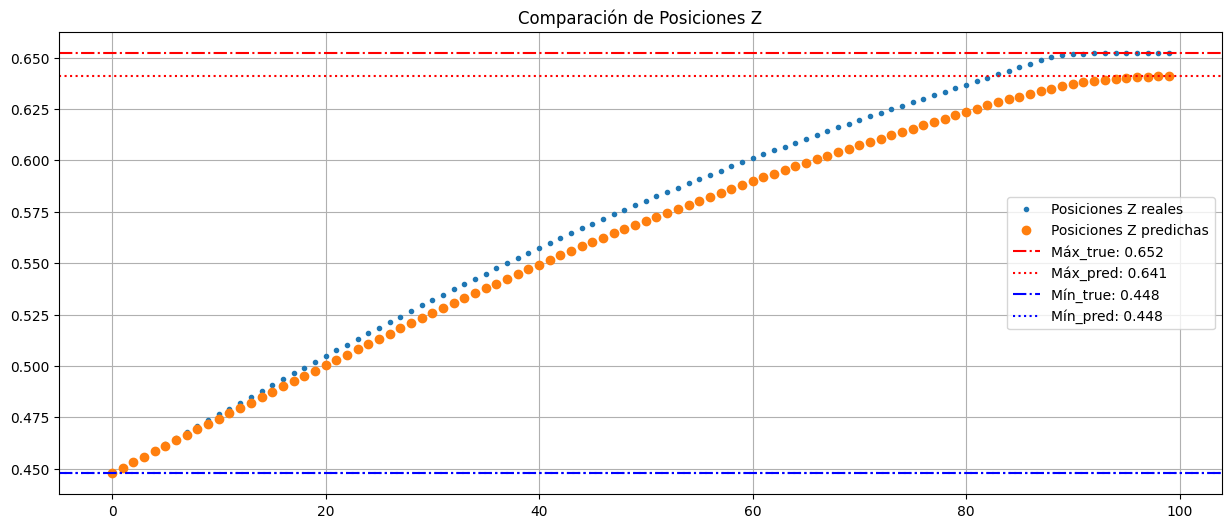

In [34]:
##Graficamos 
# Buscamos los máximos y mínimos 
y_true_max = np.max(y_true)
y_true_min = np.min(y_true)

y_pred_max = np.max(y_pred)
y_pred_min = np.min(y_pred)

# Pos z
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Posiciones Z reales', linestyle='None', marker='.')
plt.plot(y_pred, label='Posiciones Z predichas', linestyle = 'None',marker='o')
# Dibujamos los max y min
plt.axhline(y = y_true_max, color = 'red', linestyle = '-.', label=f'Máx_true: {y_true_max:.3f}')
plt.axhline(y = y_pred_max, color = 'red', linestyle = ':', label= f'Máx_pred: {y_pred_max:.3f}')
plt.axhline(y = y_true_min, color = 'blue', linestyle ='-.', label=f'Mín_true: {y_true_min:.3f}')
plt.axhline(y = y_pred_min, color = 'blue', linestyle = ':',label= f'Mín_pred:{y_pred_min: .3f}')

# plt.ylim(-35,-50) ##(-60,-30)
plt.title('Comparación de Posiciones Z')
plt.legend()
plt.grid(True)
plt.show()

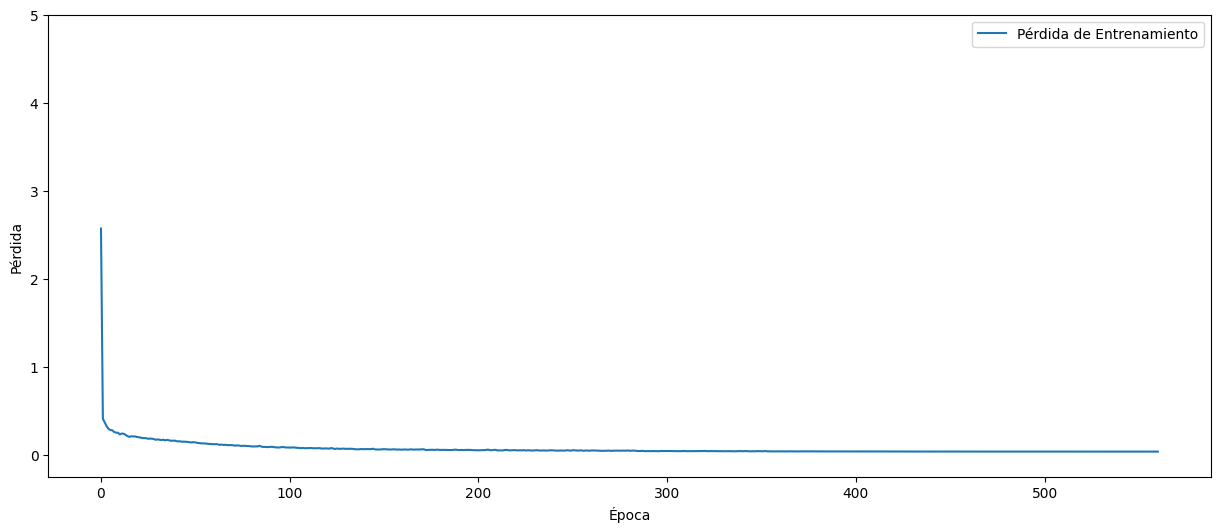

In [18]:
# Función de Pérdida durante el entrenamiento
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label = 'Pérdida de Entrenamiento')
#plt.plot(history.history['val_loss'], label = 'Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.ylim(-0.25,5)
plt.legend()
plt.show()

In [ ]:
# #Guardado de Modelo.
# autoencoder_z.save("../modelos_entrenamiento/mod_z_R0/modelo2/modelo2.keras")

# #Guardado de Scaler
# import pickle
# with open('../modelos_entrenamiento/mod_z_R0/modelo2/scaler_z2.pkl','wb') as f:
#   pickle.dump(scaler_z,f)